In [1]:
# All configs

#data_path = "../Alfrodull/experiments/ubelix/wigl/rt_noniso_p5e7_Tint500K/"
#data_path = "../Alfrodull/experiments/ubelix/wigl/rt_iso_p2e7_Ts6000/"
#data_path = "../rtc_iso_p2e7/"

#data_path = "../Alfrodull/experiments/ubelix/wigl/rt_noniso_p4e7/"
data_path = "../alf_rt_noniso_p4e7_hires/"

# path to mjolnir from execution directory, used if ran in another folder, e.g. with 'muninn' script
mjolnir_path = "./"

FIGSIZE_x = 15
FIGSIZE_y = 12

VIDEO_x = 1280
VIDEO_DISPLAY_x = 800
dpi = 296

regrided_plots = False

movies = False

quad_plots = False

single_plot = True

plot_last = True

plot_index = 1

plot_spectrum = True


In [2]:
# path to mjolnir code
import sys
sys.path.append(mjolnir_path) 

import pathlib
import re

import h5py
import imageio
import IPython.display as disp

import math

#%matplotlib notebook
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
from PIL import Image, ImageDraw, ImageFont, ImageOps
from matplotlib.backends.backend_agg import FigureCanvasAgg
# from pygifsicle import optimize

import hamarr as ham
import mjolnir_plot_helper as mph
from file_helpers import get_path_matching_regex, get_path_matching_regex_with_groups

In [3]:
try:
    output_path = pathlib.Path(output_path)
except:
    output_path = pathlib.Path(data_path) / f"report/"

In [4]:
exp_path = pathlib.Path(data_path) 
output_dir = output_path
FIGSIZE = (FIGSIZE_x, FIGSIZE_y)



In [5]:
# get planet file

planet_files = get_path_matching_regex_with_groups(
    exp_path, f"esp_output_planet_(.+).h5"
)

if len(planet_files) == 1:
    planet_name = planet_files[0]['groups'][0] 
    planet_file = planet_files[0]['path']
    
    print(f"Found planet name '{planet_name}'")
else:
    raise Exception("Error looking for single planet files. Found:", planet_files)

Found planet name 'hd189b'


In [6]:
# get grid file

grid_files = get_path_matching_regex_with_groups(
    exp_path, f"esp_output_grid_(.+).h5"
)

if len(grid_files) == 1:
    planet_g_name = grid_files[0]['groups'][0] 
    grid_file = grid_files[0]['path']
    
    print(f"Found grid file '{grid_file}'")
else:
    raise Exception("Error looking for single grid files. Found:", grid_files)

Found grid file '../hd189_alf/esp_output_grid_hd189b.h5'


In [7]:
print()
print("Planet Parameters")
print("=================")
print()

with h5py.File(planet_file, 'r') as p:
    for k in p.keys():
        print(f"{k:<30}: {str(p[k][...]):>15}")
    
    has_TSRT = "two_streams_radiative_transfer" in p
    has_RT = "radiative_transfer" in p
    
    print()
    print("Modules")
    print("-------")
    print()
    print(f"Radiative transfer: {has_RT}")
    print(f"Two stream radiative transfer: {has_TSRT}")


Planet Parameters

A                             :     [86934272.]
Cp                            :      [13226.82]
DeepModel                     :            [1.]
DiffSponge                    :            [0.]
Diffc                         :          [0.01]
DivDampP                      :            [1.]
Gravit                        :          [19.5]
HyDiff                        :            [1.]
NonHydro                      :            [1.]
Omega                         :     [3.278e-05]
P_Ref                         :     [22000000.]
RayleighSponge                :            [1.]
RayleighSpongeT               :            [0.]
Rd                            :         [3779.]
Ruv_sponge                    :        [0.0001]
Rw_sponge                     :        [0.0001]
Tint                          :          [100.]
Tmean                         :         [1161.]
Top_altitude                  :      [3600000.]
Tstar                         :         [4875.]
alf_compute_periodic

In [8]:
print()
print("Grid Parameters")
print("===============")
print()

with h5py.File(grid_file, 'r') as g:
    # print(g.keys())
              
    #for k in g.keys():
    #    print(f"{k:<30}: {str(g[k][...]):>15}")
    print(f"{'nv':<30}: {str(g['nv'][...]):>15}" )
    print(f"{'point_num':<30}: {str(g['point_num'][...]):>15}" )


Grid Parameters

nv                            :           [40.]
point_num                     :         [2562.]


In [9]:
# get count of output files
outputs = get_path_matching_regex_with_groups(
    exp_path, f"esp_output_{planet_name}_(\d+).h5"
)

# sort'em
d = {}

for o in outputs:
    p = o["path"]
    (idx_chr,) = o["groups"]
    idx = int(idx_chr)
    # print(f"{idx} - {p}")
    d[idx] = p

sorted_files = sorted(d.items())


first_idx = sorted_files[0][0]
last_idx = sorted_files[-2][0]
#last_idx = 20

print()
print("Output files")
print("============")
print()

print(f"First index: {first_idx}")
print(f"Last index: {last_idx}")

print()
print("Plotting")
print("========")
print()
print(f"Plot quad: {quad_plots}")
print(f"Plot single plot: {single_plot}")
print(f"Plot last: {plot_last}")

if plot_last:
    plot_index = last_idx
print(f"plot_index: {plot_index}" )



Output files

First index: 0
Last index: 99

Plotting

Plot quad: False
Plot single plot: True
Plot last: True
plot_index: 99


In [10]:
class args:
    pass


file_idx = 1

args.pview = ["fuptot"]
args.file = [str(exp_path)]
args.simulation_ID = [planet_name]
args.initial_file = [file_idx]
args.last_file = [file_idx]
args.horizontal_lev = [2.5e2]
args.vertical_top = ["default"]
args.split_layer = ["no_split"]
args.coordinate_sys = ["icoh"]
args.lmax_adjust = [0]
args.slice = [0, 180]
args.maketable = False
args.no_pressure_log = False
args.latlonswap = False
args.vcoord = ["pressure"]
args.pgrid_ref = [f"pgrid_{file_idx}_{file_idx}_1.txt"]
args.clevels = [40]

In [11]:
figures_dir = exp_path / "figures"
if not figures_dir.exists():
    figures_dir.mkdir(parents=True, exist_ok=True)
    
if not output_dir.exists():
    output_dir.mkdir(parents=True, exist_ok=True)

In [12]:
def plot_anim_steps(first_idx, last_idx, args, plot_filename, overwrite_anim=False):
    """Make a movie using args for mjolnir plotting functions, run over all the indexed files"""
    stride = 1
    overwrite = False
    output_anim_file = output_dir / plot_filename

    if output_anim_file.exists() and not overwrite_anim:
        print(
            f"{output_anim_file} already exists, skipping. Set overwrite_anim = True to force"
        )
        return output_anim_file

    fps = 10
    # writer = imageio.get_writer(str(output_image), fps=fps, quality=10)
    writer = imageio.get_writer(str(output_anim_file), fps=fps)

    # for dev, force to use a small number of files
    # last_idx  = 20
    # compute fig size so that it gets rounded to closest multiple of video macro_block_size
    block_size = 16
    fs_x = (math.ceil((FIGSIZE_x*dpi)/float(block_size))*block_size)/dpi
    fs_y = (math.ceil((FIGSIZE_y*dpi)/float(block_size))*block_size)/dpi
    
    fig = plt.Figure(figsize=(fs_x, fs_y), dpi=dpi)
    ax = fig.subplots(1, 1)
    
    #size=(VIDEO_x, int(VIDEO_x/FIGSIZE_x*FIGSIZE_y))

    for i in range(first_idx, last_idx + 1):

        print(f"plotting: {i: 5}/{last_idx}\r", end="")
        args.initial_file = [i]
        args.last_file = [i]
        args.pgrid_ref = [f"pgrid_{i}_{i}_1.txt"]

        fig.clear()
        ax = fig.add_subplot(111)

        pgrid_ref = exp_path / args.pgrid_ref[0]
        if pgrid_ref.exists():
            pass
        else:
            ham.define_Pgrid(
                args.file[0],
                planet_name,
                args.initial_file[0],
                args.last_file[0],
                stride,
                overwrite=overwrite,
            )

        mph.make_plot(args, False, axis=(fig, ax))

        # canvas = fig.canvas
        canvas = FigureCanvasAgg(fig)

        # Option 2: Retrieve a view on the renderer buffer...
        canvas.draw()
        buf = canvas.buffer_rgba()
        # ... convert to a NumPy array ...
        X = np.asarray(buf)
        # ... and pass it to PIL.
        # im = Image.fromarray(X)

        #import pdb; pdb.set_trace()
        writer.append_data(X)

    writer.close()

    # optimize gif output
    #optimize(str(output_image))

    return output_anim_file


def plot_steps(plot_type, first_idx, last_idx, args):
    #fig, ((ax_first, ax_last), (ax_second, ax_mid)) = plt.subplots(
    #    2, 2, figsize=FIGSIZE
    #)
    fig = plt.Figure(figsize=FIGSIZE)
    ((ax_first, ax_last), (ax_second, ax_mid)) = fig.subplots(2,2)

    i = first_idx
    args.pview = [plot_type]
    args.initial_file = [i]
    args.last_file = [i]
    args.pgrid_ref = [f"pgrid_{i}_{i}_1.txt"]

    mph.make_plot(args, False, axis=(fig, ax_first))
    ttl = ax_first.get_title()
    ax_first.set_title(ttl + "\n" + f"Initial (idx={i})")

    i = last_idx
    args.pview = [plot_type]
    args.initial_file = [i]
    args.last_file = [i]
    args.pgrid_ref = [f"pgrid_{i}_{i}_1.txt"]

    mph.make_plot(args, False, axis=(fig, ax_last))
    ttl = ax_last.get_title()
    ax_last.set_title(ttl + "\n" + f"Last (idx={i})")

    i = first_idx + 1
    args.pview = [plot_type]
    args.initial_file = [i]
    args.last_file = [i]
    args.pgrid_ref = [f"pgrid_{i}_{i}_1.txt"]

    mph.make_plot(args, False, axis=(fig, ax_second))
    ttl = ax_second.get_title()
    ax_second.set_title(ttl + "\n" + f"First step (idx={i})")

    i = (last_idx + first_idx) // 2
    args.pview = [plot_type]
    args.initial_file = [i]
    args.last_file = [i]
    args.pgrid_ref = [f"pgrid_{i}_{i}_1.txt"]

    mph.make_plot(args, False, axis=(fig, ax_mid))
    ttl = ax_mid.get_title()
    ax_mid.set_title(ttl + "\n" + f"Middle step (idx={i})")
    
    return fig


def plot_single(plot_type, plot_idx, args):
    #fig, ((ax_first, ax_last), (ax_second, ax_mid)) = plt.subplots(
    #    2, 2, figsize=FIGSIZE
    #)
    i = plot_idx
    stride = 1
    overwrite = False
    args.pgrid_ref = [f"pgrid_{i}_{i}_1.txt"]
    
    
    
    pgrid_ref = exp_path / args.pgrid_ref[0]
    if pgrid_ref.exists():
        pass
    else:
        ham.define_Pgrid(
        args.file[0],
        planet_name,
        args.initial_file[0],
        args.last_file[0],
        stride,
        overwrite=overwrite,
        )
    fig = plt.Figure(figsize=FIGSIZE)
    ax = fig.subplots(1,1)

    
    args.pview = [plot_type]
    args.initial_file = [i]
    args.last_file = [i]

    mph.make_plot(args, False, axis=(fig, ax))
    ttl = ax.get_title()
    ax.set_title(ttl + "\n" + f"idx={i}")

    
    return fig

In [13]:
def plot_anim(plotname, plotfile, first, last, args):
    print(f"plotting {plotname} to {plotfile}")
    args.pview = [plotname]
    # don't show interactive plots when not asked to

    output_image = plot_anim_steps(first_idx, last_idx, args, plotfile)

    #im = Image.open(output_image)
    return disp.Video(output_image,width=VIDEO_DISPLAY_x)

In [ ]:
# plots = [
#          ("TP", "TP_anim.gif"),
#          ("Tver", "Tver_anim.gif"),
#          ("Tlonver", "Tver_anim.gif"),
#          ("fuptot", "fuptot_anim.gif"),
#          ("fdowntot", "fdowntot_anim.gif"),
#          ("fnet", "fnet_anim.gif"),
#          ("qheat", "qheat_anim.gif"),
#          ("futprof", "futprof_anim.gif"),
#          ("fdtprof", "fdtprof_anim.gif"),
#          ("fnetprof", "fnetprof_anim.gif"),
#         ]

# for plotname, plotfile in plots:
#     print(f"plotting {plotname} to {plotfile}")
#     args.pview = [plotname]
#     output_image = plot_anim_steps(first_idx, last_idx, args, plotfile)
#     im = Image.open(output_image)
#     disp.Image(output_image, format="gif")

# Mu Star

In [ ]:
#plot_steps("mustar", first_idx, last_idx, args)

# TP Profile

In [17]:
pa = None
if movies:
    pa = plot_anim("TP", "TP_anim.mp4", first_idx, last_idx, args)
pa

In [19]:
last_idx

99

In [15]:
f = None
if quad_plots:
    f = plot_steps("TP", first_idx, last_idx, args)
f

Dataset Pressure has already been loaded into memory


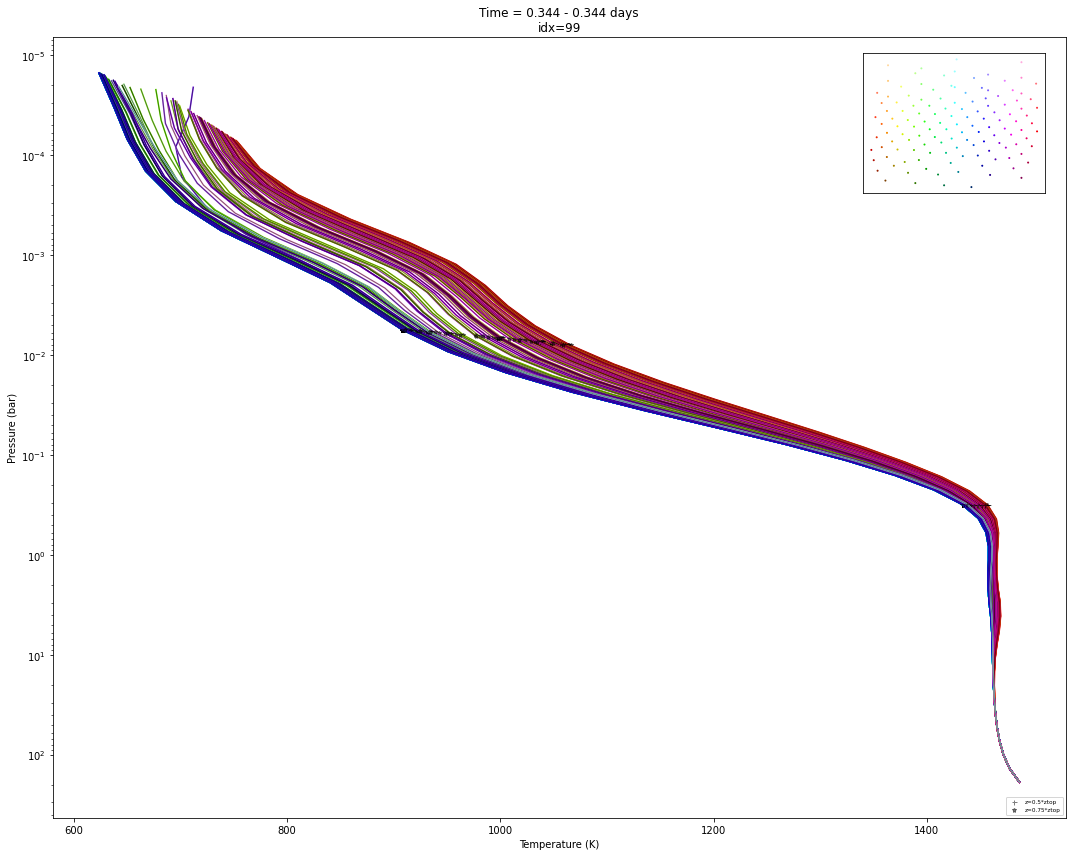

In [16]:
f = None
if plot_single:
    f = plot_single("TP", plot_index, args)
f

# Tver

In [ ]:
pa = None
if movies and regrided_plots:
    pa = plot_anim("Tver", "Tver_anim.mp4", first_idx, last_idx, args)
pa

In [ ]:
f = None
if quad_plots and regrided_plots:
    f = plot_steps("Tver", first_idx, last_idx, args)
f

In [ ]:
f = None
if plot_single:
    f = plot_single("Tver", plot_index, args)
f

# Tlonver

In [ ]:
pa = None
if movies and regrided_plots:
    pa = plot_anim("Tlonver", "Tlonver_anim.mp4", first_idx, last_idx, args)
pa


In [ ]:
f = None
if regrided_plots and quad_plots:
    f = plot_steps("Tlonver", first_idx, last_idx, args)
f

In [ ]:
f = None
if plot_single:
    f = plot_single("Tlonver", plot_index, args)
f

# Zonal wind profile ulev

In [ ]:
if movies and regrided_plots:
    plot_anim("uver", "uver_anim.mp4", first_idx, last_idx, args)

In [ ]:
f = None
if quad_plots and regrided_plots:
    f = plot_steps("uver", first_idx, last_idx, args)
f

In [ ]:
f = None
if plot_single:
    f = plot_single("uver", plot_index, args)
f

# Two Stream Radiative transfer

In [22]:
if has_TSRT:
    print("Two Stream Radiative Transfer Enabled")
else:
    print("Two Stream Radiative Transfer Disabled, no plots will appear in this group")

Two Stream Radiative Transfer Enabled


## Qheat

In [20]:
pa = None
if has_TSRT and movies and regrided_plots:
    pa = plot_anim("qheat", "qheat_anim.mp4", first_idx, last_idx, args)
    
pa

In [21]:
f = None
if has_TSRT and quad_plots and regrided_plots:
    f = plot_steps("qheat", first_idx, last_idx, args)
f

In [23]:
f = None
if has_TSRT and plot_single:
    f = plot_single("qheat", plot_index, args)
f

../hd189_alf/pgrid_99_99_1/regrid_hd189b_99.h5 not found, regridding now with default settings...
Regrid data in folder ../hd189_alf...

Vertical coordinate = pressure from file ../hd189_alf/pgrid_99_99_1.txt
Regridding time = 99...
Writing file ../hd189_alf/pgrid_99_99_1/regrid_hd189b_99.h5...
Writing file ../hd189_alf/regrid_height_hd189b_99.h5...


AttributeError: 'rg_out_new' object has no attribute 'qheat'

In [ ]:
pa = None
if has_TSRT and movies:
    pa = plot_anim("qheatprof", "qheatprof_anim.mp4", first_idx, last_idx, args)
    
pa

In [ ]:
f = None
if has_TSRT and quad_plots:
    f = plot_steps("qheatprof", first_idx, last_idx, args)
f

In [ ]:
f = None
if has_TSRT and plot_single:
    f = plot_single("qheatprof", plot_index, args)
f

In [ ]:
pa = None
if has_TSRT and movies:
    pa = plot_anim("TSqheatprof", "TSqheatprof_anim.mp4", first_idx, last_idx, args)
    
pa

In [ ]:
f = None
if has_TSRT and quad_plots:
    f = plot_steps("TSqheatprof", first_idx, last_idx, args)
f

In [ ]:
f = None
if has_TSRT and plot_single:
    f = plot_single("DGqheatprof", plot_index, args)
f

In [ ]:
pa = None
if has_TSRT and has_RT and movies:
    pa = plot_anim("DGqheatprof", "DGqheatprof_anim.mp4", first_idx, last_idx, args)
    
pa

## Total Upward Flux 

### Profile

In [ ]:
pa = None
if has_TSRT and movies:
    pa = plot_anim("TSfutprof", "futprof_anim.mp4", first_idx, last_idx, args)

pa

In [ ]:
f = None
if has_TSRT and quad_plots:
    f = plot_steps("TSfutprof", first_idx, last_idx, args)
f

In [ ]:
f = None
if has_TSRT and plot_single:
    f = plot_single("TSfutprof", plot_index, args)
f

### Horizontal

In [ ]:
pa = None

args.horizontal_lev = [1e-2]

if has_TSRT and movies and regrided_plots:
    pa = plot_anim("TSfuptot", "fuptot_anim.mp4", first_idx, last_idx, args)
    
pa

In [ ]:
f = None
if has_TSRT and quad_plots and regrided_plots:
    f = plot_steps("TSfuptot", first_idx, last_idx, args)
    
f

In [ ]:
f = None
if has_TSRT and plot_single:
    f = plot_single("TSfuptot", plot_index, args)
f

## Total Downward Flux 

### Profile

In [ ]:
pa = None
if has_TSRT and movies:
    pa = plot_anim("TSfdtprof", "fdtprof_anim.mp4", first_idx, last_idx, args)
    
pa

In [ ]:
f = None
if has_TSRT and quad_plots:
    f = plot_steps("TSfdtprof", first_idx, last_idx, args)
f


In [ ]:
f = None
if has_TSRT and plot_single:
    f = plot_single("TSfdtprof", plot_index, args)
f

### Horizontal

In [ ]:
pa = None
if has_TSRT and movies and regrided_plots:
    pa = plot_anim("TSfdowntot", "fdowntot_anim.mp4", first_idx, last_idx, args)
    
pa

In [ ]:
f = None
if has_TSRT and quad_plots and regrided_plots:
    f = plot_steps("TSfdowntot", first_idx, last_idx, args)
f

In [ ]:
f = None
if has_TSRT and plot_single:
    f = plot_single("TSfdowntot", plot_index, args)
f

## Total Net Flux 

### Profile

In [ ]:
pa = None 

if has_TSRT and movies:
    pa = plot_anim("TSfluxprof", "fluxprof_anim.mp4", first_idx, last_idx, args)
    
pa

In [ ]:
f = None
if has_TSRT and quad_plots:
    f = plot_steps("TSfluxprof", first_idx, last_idx, args)
f

In [ ]:
f = None
if has_TSRT and plot_single:
    f = plot_single("TSfluxprof", plot_index, args)
f

### Horizontal

In [ ]:
pa = None
if has_TSRT and movies and regrided_plots:
    pa = plot_anim("TSfnet", "TSfnet_anim.mp4", first_idx, last_idx, args)
    
pa

In [ ]:
f = None
if has_TSRT and quad_plots and regrided_plots:
    f = plot_steps("TSfluxprof", first_idx, last_idx, args)
f

In [ ]:
f = None
if has_TSRT and plot_single:
    f = plot_single("TSfluxprof", plot_index, args)
f

## Direct Beam Flux

### Profile

In [ ]:
f = None
if has_TSRT and plot_single:
    f = plot_single("TSfdirprof", plot_index, args)
f

## Spectrum

In [ ]:
f = None
if has_TSRT and plot_spectrum:
    f = plot_single("spectrum", plot_index, args)
f